# Introduction

Here we will begin evaluating the qt_dataset with bio-metric data generally referred to as vitals. 
We will look to see if we can build a model to predict Covid-19 based on the features in this dataset

In [1]:
# First I need to import my libraries

import numpy as np

import pandas as pd
from pandas.io.json import json_normalize
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import coremltools

Lets load up our dataset into a pandas DataFrame

In [2]:
originalData_df = pd.read_csv('qt_dataset.csv')
print("DataFrame shape: {}".format(originalData_df.shape))
originalData_df.head()

DataFrame shape: (10000, 5)


,ID,Oxy,Pulse,Temp,Result
0,0,98,65,95,Negative
1,1,96,92,95,Negative
2,2,95,92,99,Negative
3,3,97,56,96,Negative
4,4,88,94,98,Positive


## Exploratory Data Analysis
Lets first explore this dataset to see what insights we can find

Confirming here that we have a balanced dataset for our target value or Positive or Negative for Covid-19

In [3]:
originalData_df['Result'].value_counts()

Negative    5010
Positive    4990
Name: Result, dtype: int64

Mean values for all three features we are considering are relatively close to each other. But standard deviation and the range for pulse is significatly higher than the other two. 

In [4]:
originalData_df[['Oxy','Pulse','Temp']].describe()

,Oxy,Pulse,Temp
count,10000.000000,10000.000000,10000.000000
mean,92.548900,84.976600,100.000700
std,4.611197,26.305841,3.185045
min,85.000000,40.000000,95.000000
25%,88.000000,63.000000,97.000000
50%,93.000000,85.000000,100.000000
75%,97.000000,108.000000,103.000000
max,100.000000,130.000000,105.000000


<AxesSubplot:>

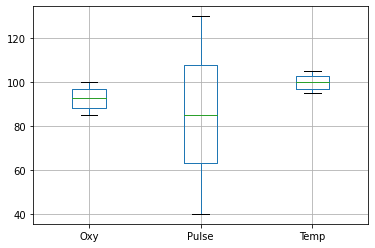

In [5]:
df = originalData_df[['Oxy', 'Pulse', 'Temp']]
df.boxplot()

Lets add some box plots to see how features are distributed for positive and negative results.

At first glance, we can see the biggest disparity between postive and negative results are for Sp02. Almost the entirety of positive cases are significantly lower than negative cases. Even extremely high Sp02 levels for positive cases dont reach the mean for negative cases. Interquartile ranges for temperatures are noticibly higher for postive cases, but minimum and maximum values are almost identical. There is little difference between positive and negative cases for our Pulse measurements.

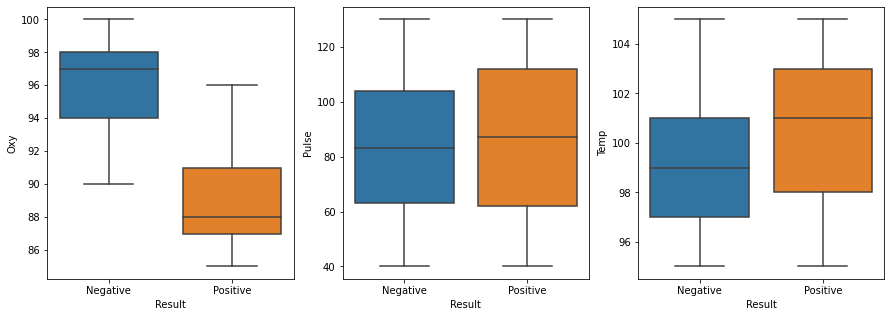

In [6]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
plot1 = sns.boxplot(x="Result", y="Oxy", data=originalData_df, ax=ax[0])
plot2 = sns.boxplot(x="Result", y="Pulse", data=originalData_df, ax=ax[1])
plot3 = sns.boxplot(x="Result", y="Temp", data=originalData_df, ax=ax[2])

This was actually very interesting to me. I would have guessed a decent correlation between these vitals. For example, I would have thought that a low Sp02 level might lead to an increase in pulse to try and compensate for low oxygen levels throughout the body. What we find here though is that there is little correlation between these three values. A change in one value does not have much impact on the others. 

In [7]:
originalData_df.corr()

,ID,Oxy,Pulse,Temp
ID,1.000000,-0.002693,-0.012499,-0.009279
Oxy,-0.002693,1.000000,-0.005724,-0.015681
Pulse,-0.012499,-0.005724,1.000000,0.009602
Temp,-0.009279,-0.015681,0.009602,1.000000


Since we are attempting to predict Postive and Negative labels, lets change our Result feature to a 1 for positive cases and 0 for negative cases. This will help with data analysis and for building a model. 

In [8]:
originalData_df['Result'] = [1 if x == 'Positive' else 0 for x in originalData_df['Result']]
originalData_df.head()

,ID,Oxy,Pulse,Temp,Result
0,0,98,65,95,0
1,1,96,92,95,0
2,2,95,92,99,0
3,3,97,56,96,0
4,4,88,94,98,1


As kind of expected from the box plots above, we see a pretty strong negative correlation between Sp02 levels and a Covid-19 diagnosis. We also see some correlation between temperature and results, although significantly less than Sp02 levels. Finally, correlation between Pulse and Results is weak to non-existent.

In [9]:
originalData_df.corr()

,ID,Oxy,Pulse,Temp,Result
ID,1.000000,-0.002693,-0.012499,-0.009279,0.011395
Oxy,-0.002693,1.000000,-0.005724,-0.015681,-0.777019
Pulse,-0.012499,-0.005724,1.000000,0.009602,0.050590
Temp,-0.009279,-0.015681,0.009602,1.000000,0.262522
Result,0.011395,-0.777019,0.050590,0.262522,1.000000


Im curious what Sp02 levels look like in a histogram for positive and negative results. Extreme Sp02 levels tend to represent the majority of Positive and Negative results.

<AxesSubplot:title={'center':'Sp02 levels for negative results'}, ylabel='Frequency'>

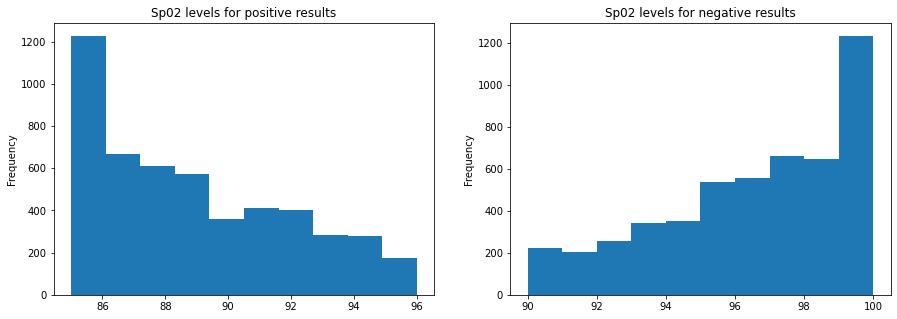

In [10]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

oxy_df = originalData_df.loc[originalData_df['Result'] == 1]
oxy_df['Oxy'].plot(kind='hist', ax=ax[0], xlabel='sp02', title="Sp02 levels for positive results")

oxy_df = originalData_df.loc[originalData_df['Result'] == 0]
oxy_df['Oxy'].plot(kind='hist', ax=ax[1], xlabel='sp02', title="Sp02 levels for negative results")

Lets also take a look at a histogram of Temperature. What we see is that the majority of positive cases are in the extreme temperature range. Interestingly enough, there is a lower frequency of negative cases for temps between 101 and 103 but with a higher frequency of cases at 104. A 104 temperature means you are twice as likely to have Covid based on the charts below. A negative covid diagnosis though does not mean you will not have a high temperature of 104. 

<AxesSubplot:title={'center':'Temp levels for negative results'}, ylabel='Frequency'>

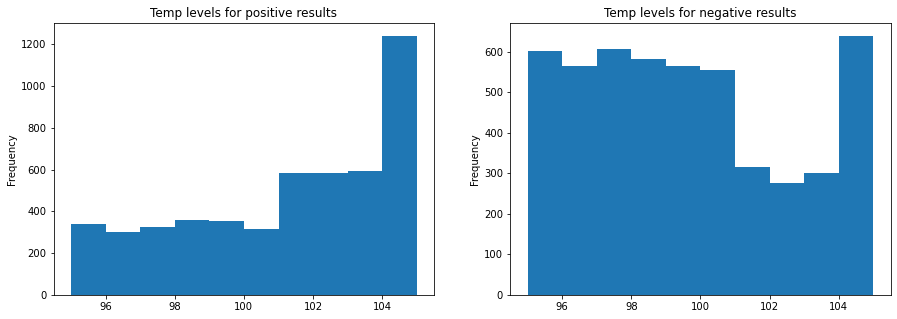

In [11]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

oxy_df = originalData_df.loc[originalData_df['Result'] == 1]
oxy_df['Temp'].plot(kind='hist', ax=ax[0], title="Temp levels for positive results")

oxy_df = originalData_df.loc[originalData_df['Result'] == 0]
oxy_df['Temp'].plot(kind='hist', ax=ax[1], title="Temp levels for negative results")

## Building a model

First lets split our data into features and targets

In [12]:
train_x = originalData_df.iloc[:,1:4].values
train_y = originalData_df.iloc[:,-1:].values

Next lets normalize the data for our models and split into train and test datasets

In [13]:
X = preprocessing.StandardScaler().fit(train_x).transform(train_x)
X_train, X_test, y_train, y_test = train_test_split( X, train_y, test_size=0.25, random_state=4)

/Users/christopherweaver/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Lets start with a logistic regression model. The model is very simple, but with so few features and some high correlation between features and targets, this model might be good.

In [14]:
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression(random_state=0).fit(X_train, y_train)

/Users/christopherweaver/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
train_score = logistic_model.score(X_train, y_train)
print("Mean accuracy for train data: {}".format(train_score))

test_score = logistic_model.score(X_test, y_test)
print("Mean accuracy for test data: {}".format(test_score))

Mean accuracy for train data: 0.9210666666666667
Mean accuracy for test data: 0.9216


In [16]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [17]:
print("Mean accuracy for train data: {}".format(clf.score(X_train, y_train)))
print("Mean accuracy for test data: {}".format(clf.score(X_test, y_test)))

Mean accuracy for train data: 1.0
Mean accuracy for test data: 1.0


Part of the purpose of this project is to design an iOS mobile app that can monitor Covid-19 without much needed from the end user. An Apple Watch series 6 can monitor pulse and Sp02 levels throughout the day, but not temperature. Temperature readings would require user input to achieve. Lets see what our models would look like if we preceeded without temperature as a feature. Due to the high correlation between Sp02 and Result, we might be able to get away with this sort or dimensionality reduction.

In [18]:
train_x2 = originalData_df.iloc[:,1:3].values
train_y2 = originalData_df.iloc[:,-1:].values

X_train2, X_test2, y_train2, y_test2 = train_test_split( train_x2, train_y2, test_size=0.25, random_state=4)

As I will mention later in this notebook, I will be using this model for my iOS app. I will pipeline the entire thing, including the standard scaler into the coreml model.

In [19]:
scaler = preprocessing.StandardScaler()
lm2 = LogisticRegression(random_state=0)

pipeline = Pipeline([('scaler', scaler), ('logistic_model2',lm2)])

logistic_model2 = pipeline.fit(X_train2, y_train2)
train_score2 = logistic_model2.score(X_train2, y_train2)
print("Mean accuracy for train data: {}".format(train_score2))

test_score2 = logistic_model2.score(X_test2, y_test2)
print("Mean accuracy for test data: {}".format(test_score2))


Mean accuracy for train data: 0.8537333333333333
Mean accuracy for test data: 0.8544


/Users/christopherweaver/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/christopherweaver/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trying another Decision Tree with only two dimensions

In [20]:
clf2_model = tree.DecisionTreeClassifier(max_depth=2)
clf2 = Pipeline([('scaler', scaler), ('clf2',clf2_model)])
clf2.fit(X_train2, y_train2)
print("Mean accuracy for train data: {}".format(clf2.score(X_train2, y_train2)))
print("Mean accuracy for test data: {}".format(clf2.score(X_test2, y_test2)))

Mean accuracy for train data: 0.8570666666666666
Mean accuracy for test data: 0.8592


/Users/christopherweaver/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Accuracy was lower for both models, but still relatively good. This shows just how much weight the Sp02 readings hold as influence over the model.

## Evaluation

First, lets check out our precision and recall values for our models that takes in Sp02, Pulse, and Temperature. 

As we can see, precision and recall are perfect for the decision tree. These model is very accurate with the test set.

In [21]:
from sklearn.metrics import precision_recall_fscore_support
y_pred = [clf.predict([x]) for x in X_test]
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='binary')

In [22]:
print("Precision: {}, Recall: {}, fscore: {}".format(precision, recall, fscore))

Precision: 1.0, Recall: 1.0, fscore: 1.0


As mentioned above, temperature data may not be readily available for our model. Taking a look at our second model that only looked at Sp02 and Pulse features, we see a precision and recall value of around 86%. This is significantly lower, but still relatively high.

It should be noted, I originally set a max depth of 4 for this deicision tree. What I saw was that the precision was very high (95%) but our recall was low (76%). This means that when our model says you have Covid-19, it is highly accurate. But in many times it will miss a diagnosis when it should make it. This is the opposite of what we wanted, in cases like predicting infectious diseases, we much prefer false positves to false negatives. I choose to use a model that is less precise but has a lower false negative rate for safety purposes.

In [23]:
y_pred = [clf2.predict([x]) for x in X_test2]
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='binary')

In [24]:
print("Precision: {}, Recall: {}, fscore: {}".format(precision, recall, fscore))

Precision: 0.8716049382716049, Recall: 0.8438247011952191, fscore: 0.8574898785425101


My current problem is if I wanted to roll this out into production, I would like a way to evaluate model outputs as a percentage. That way, if the model outputs something higher than 75%, we can notify the user and have them provide more input for another model that is more accurate. But the two model I have built above only output binary values of 1 or 0. To overcome this, I need my model to output a prediction value. 

In [25]:
y_pred_raw = [logistic_model2.predict_proba([x]) for x in X_test2]
y_pred = [0 if x[0][0] > 0.75 else 1 for x in y_pred_raw]
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='binary')
print("Precision: {}, Recall: {}, fscore: {}".format(precision, recall, fscore))

Precision: 0.8075085324232082, Recall: 0.9426294820717132, fscore: 0.8698529411764705


If we set any diagnosis to positive for Covid if our model is less than 75% sure that the user does not have Covid, we get an excellent Recall and still a very good precision. This is ideal for this scenario, we will have few false positives, but enough precision to notify the user and ask them for more information to run a more accuate model when needed.

Looking at the graph below helps give an idea what range the model is making predictions in.

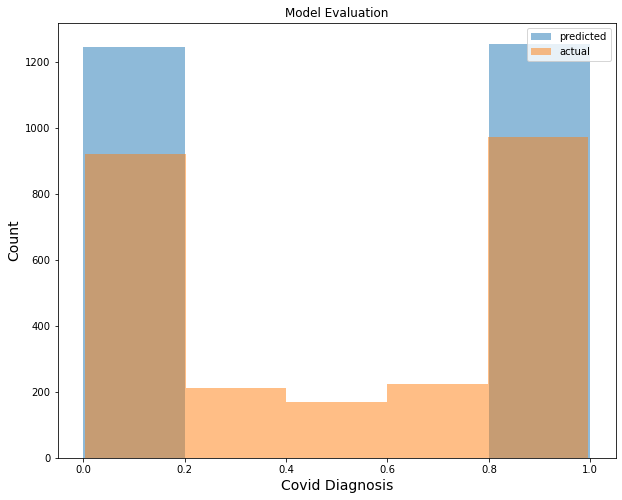

In [26]:
plt.figure(figsize=(10,8))
plt.hist(y_test, bins=5, alpha=0.5, label="predicted")
plt.hist([x[0][0] for x in y_pred_raw], bins=5, alpha=0.5, label="actual")


plt.xlabel("Covid Diagnosis", size=14)
plt.ylabel("Count", size=14)
plt.title("Model Evaluation")
plt.legend(loc='upper right')

Plotting log loss, confirms a balanced dataset and that our linear classifier is not biased towards zero or one probablities

Overall log loss: 2.789645494485006


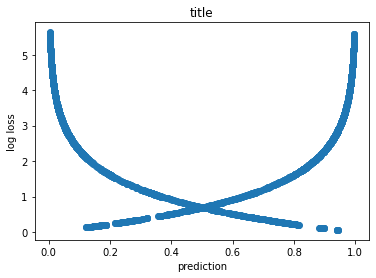

In [27]:
from sklearn.metrics import log_loss

y_pred2 = [x[0][0]for x in y_pred_raw]

print("Overall log loss: {}".format(log_loss(y_test[:,0], y_pred2)))

losses = []
for idx in range(len(y_test)): 
    losses.append( log_loss([y_test[idx][0]], [y_pred2[idx]], labels=[0,1]))

plt.scatter(y_pred2, losses)
plt.title("title")
plt.ylabel('log loss')
plt.xlabel('prediction')
plt.show()

ROC shows what we expect to see, many more false positives as we did a tradeoff for a high recall

In [28]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

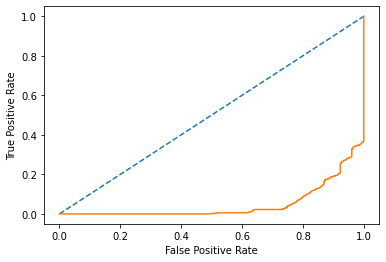

In [29]:

fpr, tpr, thresholds = roc_curve(y_test, y_pred2)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Next, lets save our model for use on an iOS app using CoreML. For now, I will be using our second logistic regression model because its inputs can come directly from the Apple watch without users needing to do anything. I choose this model over the decision tree because of the higher recall values.

In [61]:
input_features = ['Oxy','Pulse']
output_feature = "covid"
model = coremltools.converters.sklearn.convert(logistic_model2, input_features, output_feature)
model.save("Vitals.mlmodel")